<a href="https://colab.research.google.com/github/amandascarpin/sql-projects/blob/main/Answering_Business_Questions_using_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Modules and Creating Helper Functions

In [66]:
import sqlite3
from IPython.display import Image

In [67]:
#run_query(q): Takes a SQL query as an argument and returns a pandas dataframe by using the connection as a SQLite built-in context manager.
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

#run_command(c): Takes a SQL command as an argument and executes it using the sqlite module.    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

#show_tables(): calls the run_query() function to return a list of all tables and views in the database.    
def show_tables():
    q = '''SELECT
         name,
         type
        FROM sqlite_master
        WHERE type IN ("table","view");'''
    return run_query(q)

In [68]:
#Initial state of the database
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Database schema

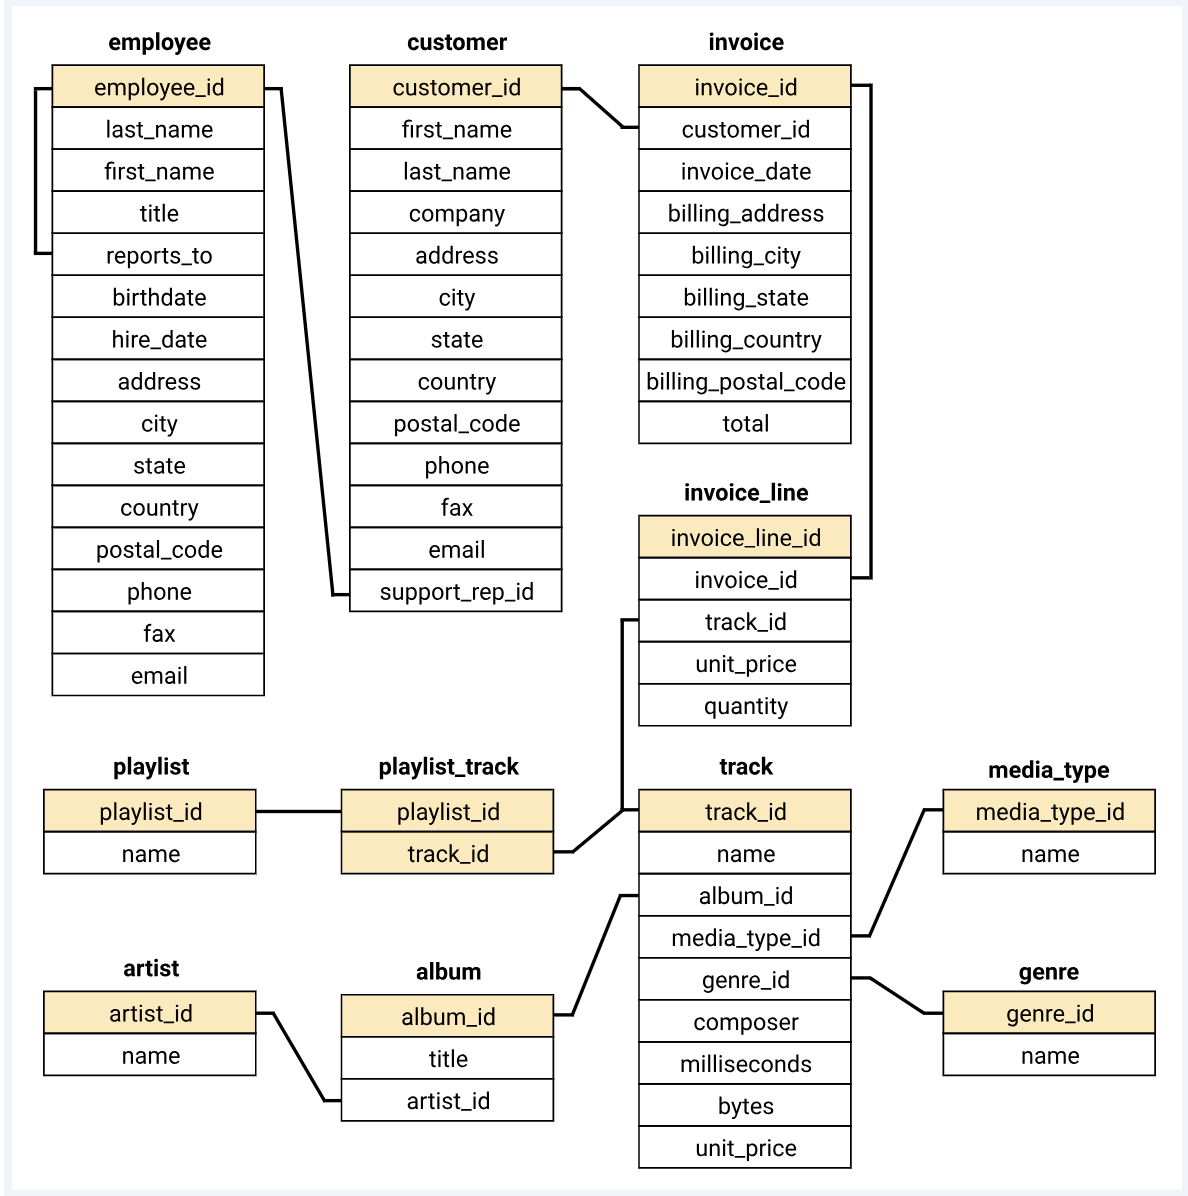

In [8]:
Image(filename='/content/chinook-schema.png')

### Top selling genres in the USA

The first question comes from the hypothetical situation where a record label asks our music store to promote its artits, and so we need to find out **which genres sell the most tracks in the USA** to select artists whose albums we should purchase.

In [24]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS float) / (
        SELECT COUNT(1) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN genre g on g.genre_id = t.genre_id
INNER JOIN track t on t.track_id = uts.track_id
GROUP BY 1
ORDER BY 2 DESC;
'''

run_query(albums_to_purchase)


,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Based on the results, we should purchase the new albums by the following artists, in that order:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

It's worth keeping in mind that combined, **these genres only make up 17% of total sales**. So we should be on the lookout for artists and albums from the 'Rock' genre, which represents 53% of sales.

### The sales agents' performance

By analyzing the purchases of customers belonging to each employee, we will be able to see if any sales support agent is performing either better or worse than the others.

In [29]:
agents_performance = '''
SELECT 
  e.first_name || " " || e.last_name name,
  e.hire_date,
  "$" || ROUND(SUM(i.total), 2) total
FROM employee e
LEFT JOIN customer c ON c.support_rep_id = e.employee_id
LEFT JOIN invoice i ON i.customer_id = c.customer_id
WHERE title = "Sales Support Agent"
GROUP BY name
ORDER BY total DESC;
'''

run_query(agents_performance)

,name,hire_date,total
0,Jane Peacock,2017-04-01 00:00:00,$1731.51
1,Margaret Park,2017-05-03 00:00:00,$1584.0
2,Steve Johnson,2017-10-17 00:00:00,$1393.92


The difference among the three sales support agents' total sales is not very large, and it may be explained by the time each employee has been working in the company, i.e. their hiring dates. **The earlier an employee was hired, the more sales he or she has made.**

### Sales by country

Here, we'll analyze the sales data for customers from each different country.

In [59]:
sales_by_country = '''
WITH 
  sales_by_country AS
    (
      SELECT
        CASE
          WHEN 
            (
              SELECT COUNT(customer_id)
              FROM customer
              WHERE country=c.country
            ) = 1 THEN 'Other'
          ELSE c.country
        END AS country,
        COUNT(DISTINCT(c.customer_id)) number_of_customers,
        SUM(i.total) total_value_sales,
        SUM(i.total)/COUNT(DISTINCT(c.customer_id)) avg_sales_per_customer,
        SUM(i.total)/COUNT(i.invoice_id) avg_order_value
        FROM customer c
        INNER JOIN invoice i on c.customer_id=i.customer_id
        GROUP BY 1
      ),
        
    sales_by_country_reorder AS 
      (
        SELECT
          sbc.*,
          CASE
            WHEN sbc.country = "Other" THEN 1
            ELSE 0
          END AS sort_other
        FROM sales_by_country sbc
        ORDER BY sort_other, sbc.total_value_sales DESC
      )
        
SELECT
  country,
  number_of_customers,
  total_value_sales,
  avg_sales_per_customer,
  avg_order_value
  FROM sales_by_country_reorder;

'''
run_query(sales_by_country)

,country,number_of_customers,total_value_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571
